# The boids model

In this notebook we explore the simple model developed for flocking birds. In the literature these models are sometimes referred to as *boids*, following the terminology used in the initial work done by Craig Reynolds [Rey87].

We're going to construct a simulation that performs averaging of velocity vectors for boids in the flock.This is slightly more advanced than the standard Vicsek mdoel, which assumes constant common velocity.

In [1]:
import numpy as np

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt
import matplotlib.animation as animation

The basic approach to flocking is to first assign each boid in the flock an initial position and direction, and then to allow these to evolve over time under the influence of an appropriate local rule. We'll stick to two dimensions for simplicity of visualisation: there's no reason we couldn't extend this approach to three dimensions, though.

There are lots of ways to do this, but one of the most efficient uses linear algebra to represent the boids' positions and velocities as matrices. We can then use `numpy` to pefrom the calculations effectively by manipulating the matrices as a whole.

Most of the complexity is in the `evolve` method. This performs several steps at each iteration:

1. Determine the pairwise distances between all boids
2. Generate masks for the boids that are "close" (to be avoided), and the boids that are "neighbours" (to be aligned with)
3. Compute the component velocities corresponding to the desires to separate from too-close boids, and to align and stay with neighbours
4. Update the boids' velocities using these three components
5. Update the boids' positions using these velocities

The way these steps are coded is quite compact, for performance.

In [2]:
def randomRadians(N):
    "Draw N random samples between 0 and 2 pi radians."
    return np.random.uniform(0, 2 * np.pi, N)

In [3]:
class Flock():
    
    def __init__(self, N=500, width=400, height=400,
                minVelocity=0.5, maxVelocity=2.0, maxAcceleration=0.03):
        self._N = N
        self._width = width
        self._height = height
        self._iteration = 0
        self._minV = minVelocity
        self._maxV = maxVelocity
        self._maxA = maxAcceleration

        # initial velocities
        self._vel = np.vstack([np.cos(randomRadians(N)),  np.sin(randomRadians(N))]).T

        # initial positions
        r = min(width, height) / 2 * np.random.uniform(0, 1, N)
        self._pos = np.vstack([width/2 +  np.cos(randomRadians(N)) * r,  
                               height/2 + np.sin(randomRadians(N)) * r]).T


    def positions(self):
        return (boids._pos[:,0], boids._pos[:,1])


    def velocities(self):
        return (boids._vel[:,0], boids._vel[:,1])

    
    def count(self, mask): 
        "Count the number of boids included in the mask."
        return np.maximum(mask.sum(axis=1), 1).reshape(self._N, 1)

    
    def limitAcceleration(self, steer):
        "Limit the accelerations of boids to maxA."
        norm = np.sqrt((steer * steer).sum(axis=1)).reshape(self._N, 1)
        np.multiply(steer, self._maxA / norm, out=steer, where=norm > self._maxA)
        return steer

    
    def closeBoids(self, dist):
        "Construct a mask of the boids that are too close for comfort."
        return (dist > 0) * (dist < 25)
        

    def neighbouringBoids(self, dist):
        "Construct a mask of the boids considered neghbours."
        return (dist > 0) * (dist < 50)
 
    
    def evolve(self):
        n = self._N
        
        # compute pairwise distances between all boids
        dx = np.subtract.outer(self._pos[:,0], self._pos[:,0])
        dy = np.subtract.outer(self._pos[:,1], self._pos[:,1])
        dist = np.hypot(dx, dy)

        # find the masks classifying the different boids
        closeMask = self.closeBoids(dist)
        neighbourMask = self.neighbouringBoids(dist)

        target = np.dstack((dx, dy))
        target = np.divide(target, dist.reshape(n, n, 1)**2, out=target, where=dist.reshape(n,n,1) != 0)

        # force of separation between close boids (inner mask)
        steer = (target * closeMask.reshape(n, n, 1)).sum(axis=1) / self.count(closeMask)
        norm = np.sqrt((steer * steer).sum(axis=1)).reshape(n, 1)
        steer = self._maxV * np.divide(steer, norm, out=steer, where=norm != 0) - self._vel
        separation = self.limitAcceleration(steer)

        # force of alignment of velocities with neighbours (outer mask)
        target = np.dot(neighbourMask, self._vel) / self.count(neighbourMask)
        norm = np.sqrt((target * target).sum(axis=1)).reshape(n, 1)
        target = self._maxV * np.divide(target, norm, out=target, where=norm != 0)
        steer = target - self._vel
        alignment = self.limitAcceleration(steer)

        # force of cohesion between neighbours (outer mask)
        target = np.dot(neighbourMask, self._pos)/ self.count(neighbourMask)
        desired = target - self._pos
        norm = np.sqrt((desired * desired).sum(axis=1)).reshape(n, 1)
        desired *= self._maxV / norm
        steer = desired - self._vel
        cohesion = self.limitAcceleration(steer)

        # compute the sum of therse three forces (velocities)
        self._vel += 1.5 * separation + alignment + cohesion

        # move the boids
        norm = np.sqrt((self._vel * self._vel).sum(axis=1)).reshape(n, 1)
        np.multiply(self._vel, self._maxV / norm, out=self._vel, where=norm > self._maxV)
        np.multiply(self._vel, self._minV / norm, out=self._vel, where=norm < self._minV)
        self._pos += self._vel + (self._width, self._height)
        self._pos %= (self._width, self._height)
        
        self._iteration += 1

We can now create a flock.

In [4]:
boids = Flock(500)

A flock is a moving set of points, with the points and their velocities changing over time. This is naturally represented as a set of line segments with arrowheads to denote direction and speed of movement. We can use the `quiver` function in `matplotlib` to create such a diagram in one call.

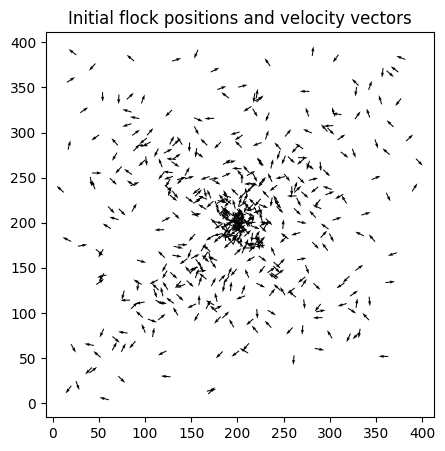

In [6]:
# create a figure
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# retrieve the initial positions and directions of the flock
X, Y = boids.positions()
dX, dY = boids.velocities()
angle = (np.arctan2(dY, dX))
U, V = np.cos(angle), np.sin(angle)
plt.quiver(X, Y, U, V, angles="xy", animated=True)

ax.set_title('Initial flock positions and velocity vectors')
plt.show()

I've left the axis labels on to show the scale the flock is described at: the numbers here relate to the distances in the `closeBoids` and `neighbouringBoids` methods.

Unsurprisingly there is little or no structure in this flock &ndash; and anything you *do* see is basically random. The hypothesis of flocking is that structure will emerge from the pairwise interactions between the boids, following the local rules of separation, alignment, and cohesion. The easiest way to see if this is actually the case is by computing the evolution over time and stacking the pictures into a movie that lets us see the changes visually. Again, `matplotlib` is a useful tool here, as it has animation operatiopns built-in.

The simulation is quite slow, as we need to perform the rule calculations at every step. However, the `quiver` object has some helper methods we can use to simplify plotting: we can update the positions of the boids and the arrows attached to them, and change the diagram rather than re-creating it from scratch at every frame.

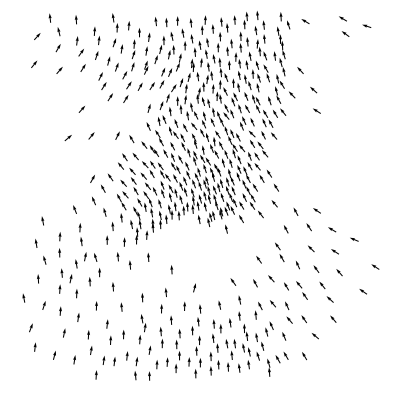

In [8]:
# create a figure
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.axis('off')                     # get rid of axis ticks and labels

# new quiver tied to our new axes (otherwise we won't see anything!)
quiver = ax.quiver(X, Y, U, V, angles="xy", animated=True)


def updateFlock(t, boids, quiver):
    "Update the quiver as the boids move."
    boids.evolve()

    # update the position and velocity vectors from the flock
    X1, Y1 = boids.positions()
    dX, dY = boids.velocities()
    angle = (np.arctan2(dY, dX))
    U1, V1 = np.cos(angle), np.sin(angle)

    # update the quiver plot
    quiver.set_UVC (U1, V1)
    quiver.set_offsets(np.c_[X1, Y1])

    return quiver
    

# generate the animation
anim = animation.FuncAnimation(fig, updateFlock, fargs=(boids, quiver), frames=1000, interval=50)
anim.save(filename="../../datasets/flock.mkv", writer="ffmpeg")
plt.show()

Playing the movie will show the way the boids flock. What sorts of patterns emerge? If you look closely you'll see micro-scale changes as well as meso-scale, such as boids oscillating from side to side as they try to align with the neighbours.

You'll notice that they "fly" off one side an appear at the other. This makes it easier to keep the flock in the frame: you might want to try changing this and "pan" the frame to keep track of the centre of the flock. You could also try adjusting the local rules, or adding weights to the different velocity components, or changing the distances that have boids classified as "close" or "neighbours"..

## References

[Rey87] Craig Reynolds. "Flocks, Herds, and Schools: A Distributed Behavioral Model". Computer Graphics **21**(4), pp. 25-34. 1987.

## Acknowledgements

The inspiration and basic mathematics for this code comes from an [example](https://examples.holoviz.org/gallery/boids/boids.html) in the gallery of the [HoloViz tools](https://holoviz.org/), which I have restructured and ported to the tooling we've used elsewhere in this module. There are lots of other examples with different rules.